In [2]:
import os
import re
import pandas as pd
import numpy as np
import zipfile
import requests
import io
import wordcloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from xgboost import XGBClassifier
import pickle
import matplotlib.pyplot as plt

In [3]:
class email:
    def __init__(self, id, message_id, data, subject, sender, receiver, day_week, time, time_zone, date, beginning, farewell, answer, length, relative_path):
        self._id = id
        self._message_id = message_id
        self._data = data
        
        # Verificar si 'subject' es una lista y convertirlo a cadena si es necesario
        if isinstance(subject, list):
            subject = " ".join(subject)
        
        self._subject = subject
        self._sender = sender
        self._receiver = receiver
        self._number_of_receivers = len(receiver)
        self._day_week = day_week
        self._time = time
        self._time_zone = time_zone
        self._date = date
        self._responded = False
        self._responses = set()
        self._beginning = beginning
        self._farewell = farewell
        self._answer = answer
        self._length = length

        # Determinar si el correo es una respuesta y almacenar el resultado
        self._is_reply = self._subject.startswith("Re: ")
        
        self._relative_path = relative_path

# Luego, al crear una instancia de 'email', esta lógica se ejecutará automáticamente


In [4]:
def email_to_dict(email):
    return email.__dict__

In [5]:
def read_email(filename, message_ids, id):
    with open(filename, 'r', errors='ignore') as file:
        data = file.read()
        id = id
        Date = r'Date: (\w+), (\d+ \w+ \d+) (\d+:\d+:\d+) (-\d{4} \(.*?\))'
        coincidencias = re.findall(Date, data)
        for day_week, date, time, time_zone in coincidencias:
            day_week = day_week
            date = date
            time = time
            time_zone = time_zone
            
        subject = re.findall(r'Subject: (.*)',data)
        
        message_id = re.search(r'Message-ID: (.*)',data)
        if message_id:
            message_id = message_id.group(1)
            
        sender_match = re.search(r'\nFrom: (.*)', data)
        if sender_match:
            sender = sender_match.group(1)
        else:
            sender = None
        
        receiver = re.findall(r'\nTo: (.*)',data)
        input_data = str(receiver)[1:-1]
        receiver_list = input_data.split(', ')
        receiver_list = [receiver.strip() for receiver in receiver_list]
        receiver_list = [s.replace("'", "") for s in receiver_list]
        receiver = [s.replace("\"", "'") for s in receiver_list]
        
        
        beginning_pattern = (r"(?:\b(?:hello|hi|hey|good (?:morning|afternoon|evening)|greetings|dear|my dearest|hi there|hello there|hi all|hi everyone|hello everyone|dearest|yo|what's up|hey pal|yolo|howdy|how's it going|how are you|what's happening|what's new|good to see you|long time no see|it's been a while|what's cracking|how's everything))\b")
        beginning = re.findall(beginning_pattern, data, flags=re.IGNORECASE)
        
        
        farewell_pattern = r"(?:\b(?:Sincerely|Regards|Best regards|Kind regards|Yours sincerely|Yours faithfully|Best wishes|Take care|Warm regards|With gratitude|With best regards|Cheers|Cordially|Respectfully|Until next time|All the best|Have a great day|Talk to you soon|Looking forward to hearing from you|With thanks|Later|Catch you later|Farewell|Peace out|Stay well|All my best|Goodbye|ByeFond regards|Take it easy|So long|See you around|Keep in touch|With warm regards|With all my heart)\b)"
        farewell = re.findall(farewell_pattern, data, flags=re.IGNORECASE)
        
        if re.search(r"-----Original Message-----", data):
            answer = 1
        elif subject[0].startswith("Re:"):
            answer = 1
        else:
            answer = 0
        
        
        body_b = data.find("X-FileName:")
        if body_b != -1:
            end_l = data.find("\n", body_b)
            if end_l != -1:
                body = data[end_l + 1:]
                words = body.split()
        length = len(words)

        relative_path = os.path.relpath(filename, start=os.path.join(os.getcwd(), '..'))
        
        if message_id in message_ids:
            return None
        else:
            email_object = email(id, message_id, data, subject, sender, receiver, day_week,time, time_zone, date,beginning,farewell, answer, length, relative_path)
            return email_object
        

In [6]:
list_of_emails = []
set_of_message_ids = set()
counter = 0


# base_dir = "../maildir"
base_dir = os.path.join(os.path.dirname(os.getcwd()), 'maildir')


for root, dirs, files in os.walk(base_dir):
    for file in files:
        file_path = os.path.join(root, file)
        tmp_email = read_email(file_path, set_of_message_ids, counter)
        counter += 1
        if tmp_email is not None:
            list_of_emails.append(tmp_email)
            set_of_message_ids.add(tmp_email._message_id)

In [7]:
# Contar cuántos correos son respuestas, teniendo en cuenta que '_subject' podría ser una lista
count_replies = 0
for email in list_of_emails:
    subject = email._subject
    # Si '_subject' es una lista, unimos sus elementos en una cadena
    if isinstance(subject, list):
        subject = " ".join(subject)
    # Verificar si el asunto resultante contiene 'Re:'
    if subject.startswith("Re: "):
        count_replies += 1

# Imprimir el total de correos que son respuestas
print(f'Total de correos que son respuestas: {count_replies}')

Total de correos que son respuestas: 0


In [8]:
def find_parent_mail(_id, _subject, _receiver, _date, _time):
    _subject = re.sub(r'Re: ', '', _subject)
    _subject = _subject.replace(' ', '')
    for email in list_of_emails:
        email_datetime_str = email._date + ' ' + email._time
        email_datetime = datetime.strptime(email_datetime_str, '%d %b %Y %H:%M:%S')
        _datetime_str = _date + ' ' + _time
        _datetime = datetime.strptime(_datetime_str, '%d %b %Y %H:%M:%S')
        if email._subject.replace(' ', '').replace('Re:', '') == _subject.replace(' ', '') and email._sender in _receiver and email_datetime < _datetime:
            email._responded = True
            email._responses.add(_id)

In [9]:
for email in list_of_emails:
    if email._is_reply:
        id = email._id
        subject = email._subject
        receiver = email._receiver
        date = email._date
        time = email._time
        find_parent_mail(id, subject, receiver, date, time)

In [10]:
for email in list_of_emails:
    email._responses = list(email._responses)

In [11]:
for counter in range(1, len(list_of_emails), 100000):
    emails_dict_list = [email_to_dict(email) for email in list_of_emails[(counter - 1):(counter + 99999)]]
    file_path = f'../data/emails{(counter // 100000) + 1}.json'
    with open(file_path, 'w') as json_file:
        json.dump(emails_dict_list, json_file)

In [12]:
class email:
    def __init__(self, id, message_id, data, subject, sender, receiver, day_week, time, time_zone, date,
                 beginning, farewell, answer, length, relative_path, is_spam):
        self._id = id
        self._message_id = message_id
        self._data = data
        self._subject = subject
        self._sender = sender
        self._receiver = receiver
        self._day_week = day_week
        self._time = time
        self._time_zone = time_zone
        self._date = date
        self._beginning = beginning
        self._farewell = farewell
        self._answer = answer
        self._length = length
        self._relative_path = relative_path
        self._is_spam = is_spam

def download_and_extract_emails(url):
    response = requests.get(url)
    if response.status_code == 200:
        if response.content[:2] == b'PK':
            with zipfile.ZipFile(io.BytesIO(response.content)) as zip_file:
                zip_file.extractall("/tmp/emails")  # Extract to a directory named "/tmp/emails"
            return True
        else:
            print("The downloaded content does not appear to be a ZIP file.")
            return False
    else:
        print(f"Request failed with status code: {response.status_code}")
        return False

def parse_email(file_path, is_spam):
    with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
        data = file.read()
        subject_match = re.search(r"Subject: (.*)", data)
        sender_match = re.search(r"From: (.*)", data)
        receiver_match = re.search(r"To: (.*)", data)
        date_match = re.search(r"Date: (.*)", data)
        
        subject = subject_match.group(1) if subject_match else "No Subject"
        sender = sender_match.group(1) if sender_match else "No Sender"
        receiver = receiver_match.group(1) if receiver_match else "No Receiver"
        date = date_match.group(1) if date_match else "No Date"
        
        return email(1, "MessageID", data, subject, sender, [receiver], "Monday", "12:00", "UTC", date, [], [], 0, len(data), file_path, is_spam)

def load_emails(base_path):
    emails = []
    for category in ['ham', 'spam']:
        directory_path = os.path.join(base_path, category)
        is_spam = (category == 'spam')
        for filename in os.listdir(directory_path):
            file_path = os.path.join(directory_path, filename)
            email_obj = parse_email(file_path, is_spam)
            emails.append(email_obj)
    return emails

def convert_emails_to_dataframe(emails):
    data = {
        'Subject': [mail._subject for mail in emails],
        'Sender': [mail._sender for mail in emails],
        'Receiver': [mail._receiver for mail in emails],
        'Content': [mail._data for mail in emails],
        'Is Spam': [mail._is_spam for mail in emails]
    }
    df = pd.DataFrame(data)
    return df

# Main execution
url = 'https://github.com/fenago/datasets/blob/main/emails.zip?raw=true'
if download_and_extract_emails(url):
    emails = load_emails('/tmp/emails')
    df = convert_emails_to_dataframe(emails)
    print(df)  # Print first few rows to verify
    


                                                Subject  \
0                                Re: liberal defnitions   
1                              problems with apt update   
2     Re: Are bad developer libraries the problem wi...   
3                       [Spambayes] all but one testing   
4                    RE: Gecko adhesion finally sussed.   
...                                                 ...   
2995                           Mothers you want to fuck   
2996  Attn: NORTON SYSTEMWORKS 2002 BLOWOUT!        ...   
2997                         -> IN THE NEWS TODAY <----   
2998  =?iso-2022-jp?B?GyRCJDckOCRfJEgkYiRiJE4lMyVpJV...   
2999  Get the Child Support You Deserve             ...   

                                                 Sender  \
0                                      ThosStew@aol.com   
1                      Mark Derricutt <mark@talios.com>   
2     Luciano Miguel Ferreira Rocha <strange@nsk.no-...   
3                      nas@python.ca (Neil Schemenauer)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(df['Subject'], df['Is Spam'], test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer(stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Guardar el vectorizador en un archivo .pickle
with open('vectorizer.pickle', 'wb') as handle:
    pickle.dump(vectorizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Guardar las matrices transformadas
with open('X_train_tfidf.pickle', 'wb') as handle:
    pickle.dump(X_train_tfidf, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('X_test_tfidf.pickle', 'wb') as handle:
    pickle.dump(X_test_tfidf, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [14]:
logreg = LogisticRegression()
logreg.fit(X_train_tfidf, y_train)

LogisticRegression()

In [15]:
y_pred = logreg.predict(X_test_tfidf)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.8766666666666667
Confusion Matrix:
[[504   1]
 [ 73  22]]
Classification Report:
              precision    recall  f1-score   support

       False       0.87      1.00      0.93       505
        True       0.96      0.23      0.37        95

    accuracy                           0.88       600
   macro avg       0.92      0.61      0.65       600
weighted avg       0.89      0.88      0.84       600



In [16]:
xgb_clf = XGBClassifier()
xgb_clf.fit(X_train_tfidf, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [17]:
y_pred_xgb = xgb_clf.predict(X_test_tfidf)
with open("modelo_entrenado.pickle", "wb") as archivo:
    pickle.dump(xgb_clf, archivo)
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))
print("Classification Report:")
print(classification_report(y_test, y_pred_xgb))

Accuracy: 0.9016666666666666
Confusion Matrix:
[[494  11]
 [ 48  47]]
Classification Report:
              precision    recall  f1-score   support

       False       0.91      0.98      0.94       505
        True       0.81      0.49      0.61        95

    accuracy                           0.90       600
   macro avg       0.86      0.74      0.78       600
weighted avg       0.90      0.90      0.89       600



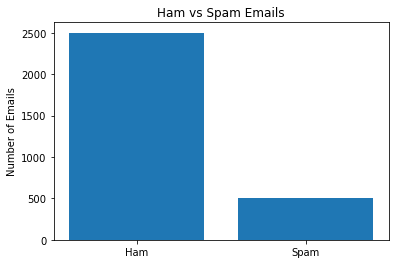

In [18]:
def visualize_email_distribution(df):
    if 'Is Spam' not in df.columns:
        print("La columna 'Is Spam' no existe en el DataFrame.")
    else:
        # Contar la cantidad de correos ham y spam
        ham_count = df[df['Is Spam'] == False].shape[0]
        spam_count = df[df['Is Spam'] == True].shape[0]
        
        # Crear un gráfico de barras
        plt.bar(['Ham', 'Spam'], [ham_count, spam_count])
        plt.ylabel('Number of Emails')
        plt.title('Ham vs Spam Emails')
        plt.show()

visualize_email_distribution(df)



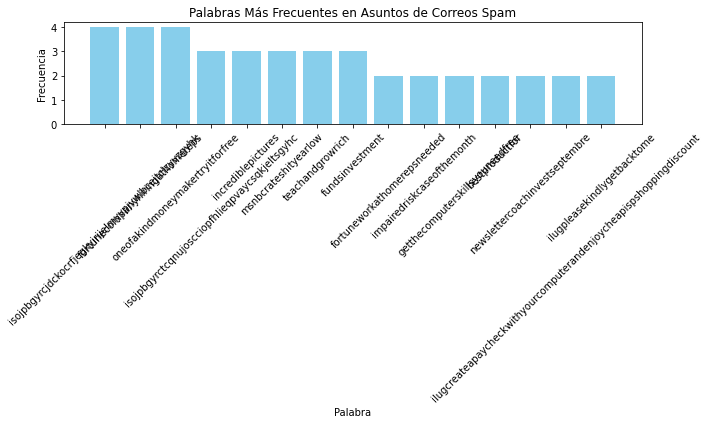

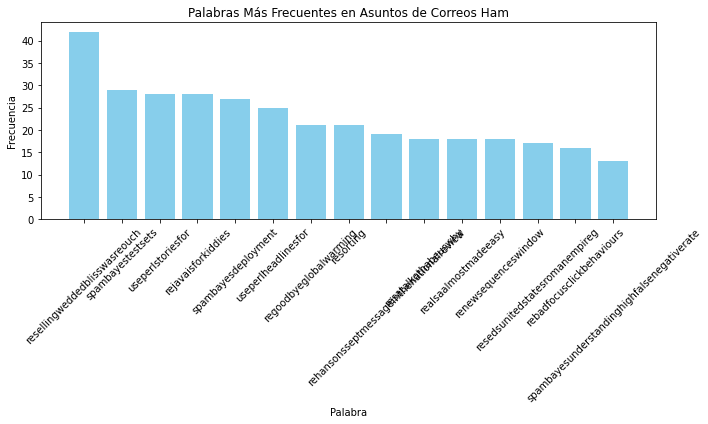

In [19]:
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
import re

# Asumiendo que 'df' es el DataFrame ya cargado
stop_words = set(stopwords.words('english'))

def clean_text(text):
    return re.sub(r'[^a-zA-Z\\s]', '', text.lower())

def get_frequent_words(subjects):
    cleaned_text = ' '.join(clean_text(subject) for subject in subjects)
    word_counts = Counter(word for word in cleaned_text.split() if len(word) >= 3 and word not in stop_words)
    return dict(word_counts.most_common(15))

def plot_frequent_words(word_freq, title):
    plt.figure(figsize=(10, 6))
    plt.bar(word_freq.keys(), word_freq.values(), color='skyblue')
    plt.title(title)
    plt.xlabel('Palabra')
    plt.ylabel('Frecuencia')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Análisis de asuntos de correos spam
spam_subjects = df[df['Is Spam'] == True]['Subject']
spam_word_freq = get_frequent_words(spam_subjects)
plot_frequent_words(spam_word_freq, 'Palabras Más Frecuentes en Asuntos de Correos Spam')

# Análisis de asuntos de correos ham
ham_subjects = df[df['Is Spam'] == False]['Subject']
ham_word_freq = get_frequent_words(ham_subjects)
plot_frequent_words(ham_word_freq, 'Palabras Más Frecuentes en Asuntos de Correos Ham')


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data/spam_words.png'

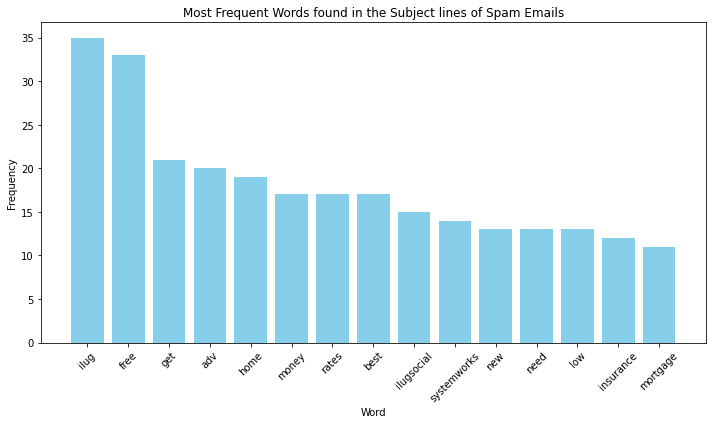

In [20]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import re


# Lista manual de stopwords comúnmente usadas en inglés
manual_stopwords = {
    'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 
    'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', 
    "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 
    'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 
    'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 
    'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 
    'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 
    'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 
    'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 
    'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', 
    "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 
    'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', 
    "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"
}

def clean_text(text):
    return re.sub(r'[^a-zA-Z\s]', '', text.lower())

def get_frequent_words(subjects, stop_words):
    cleaned_text = ' '.join(clean_text(subject) for subject in subjects)
    word_counts = Counter(word for word in cleaned_text.split() if len(word) >= 3 and word not in stop_words)
    return dict(word_counts.most_common(15))

def plot_frequent_words(word_freq, title, filename):
    plt.figure(figsize=(10, 6))
    plt.bar(word_freq.keys(), word_freq.values(), color='skyblue')
    plt.title(title)
    plt.xlabel('Word')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

# Análisis de asuntos de correos spam
spam_subjects = df[df['Is Spam'] == True]['Subject']
spam_word_freq = get_frequent_words(spam_subjects, manual_stopwords)
plot_frequent_words(spam_word_freq, 'Most Frequent Words found in the Subject lines of Spam Emails', '/mnt/data/spam_words.png')

# Análisis de asuntos de correos ham
ham_subjects = df[df['Is Spam'] == False]['Subject']
ham_word_freq = get_frequent_words(ham_subjects, manual_stopwords)
